# L-BF-IS for a 1000-dimensional problem 
source: https://www.sciencedirect.com/science/article/pii/S0021999118301955 (section 3.3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models import NN, train_NN
import torch
from tqdm.notebook import tqdm
import math

Firstly, we introduce the LF/HF evaluation functions and origin probability distribution $p(\xi)$.

In [2]:
# the element function
def element(xi):
    k   = torch.arange(1,1001)
    vec = torch.sin(k)/k
    return 2 - xi@vec

# the finite sum function
def finite_sum(xi, M):
    res  = torch.zeros(len(xi))
    elem = element(xi)
    for m in range(M+1):
        res += elem**m/math.factorial(m)
    return res

# LF evaluation function
def x_L(xi):
    M = 3
    return finite_sum(xi, M)

# HF evaluation function
def x_H(xi):
    elem = element(xi)
    return elem.exp()

# sampling xi by p(xi)
def sample_xi_p(N):
    return torch.rand(N, 1000)

In [3]:
# gradient of x_H
def grad_x_H(xi):
    k   = torch.arange(1,1001)
    vec = (torch.sin(k)/k).unsqueeze(0)
    return -x_H(xi).unsqueeze(-1) @ vec

# gradient of x_L
def grad_x_L(xi):
    M   = 3
    k   = torch.arange(1,1001)
    vec = (torch.sin(k)/k).unsqueeze(0)
    fsm = finite_sum(xi, M-1).unsqueeze(-1)
    return -fsm@vec

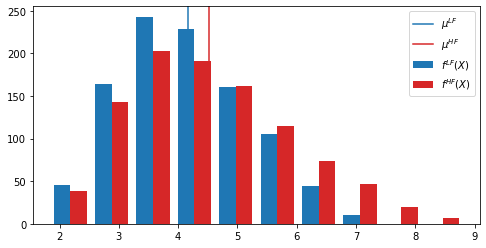

In [5]:
xi = sample_xi_p(1000)

xL = x_L(xi)
xH = x_H(xi)

plt.figure(figsize=(8,4))
plt.hist([xL,xH],label=[r'$f^{LF}(X)$',r'$f^{HF}(X)$'],color=['tab:blue','tab:red'])
plt.axvline(x = ExL, color = 'tab:blue', label = r'$\mu^{LF}$')
plt.axvline(x = ExH, color = 'tab:red', label = r'$\mu^{HF}$')
plt.legend()
plt.savefig('dim-1000-BFdata.png',format='pdf',dpi=200)

We evaluate the LF mean and HF mean using 1,000,000 simulated samples. 
The LF mean will be implemented in our algorithm, and the HF mean is only used for correctness check.

In [9]:
# evaluate LF and HF mean
xi  = sample_xi_p(int(1e6))
ExL = x_L(xi).mean()
ExH = x_H(xi).mean()

bound      = torch.tensor([0, 1]) # range of inputs

For computational convenience, we apply an NN for setting up an initial state for the Langevin algorithm.

In [5]:
def loss(T, xi): # loss function for training the NN
    return torch.norm(x_L(T(xi)) - ExL).square()

input_size = 1000 # the stochastic input dimension
bound      = torch.tensor([0, 1]) # range of inputs
T = NN(input_size,bound)

xi_trn = sample_xi_p(5000)
xi_val = sample_xi_p(1000)

trn_losses, val_losses = train_NN(T, xi_trn, loss, xi_val) # train the NN

plt.plot(trn_losses,label='trn loss')
plt.plot(val_losses,label='val loss')
plt.yscale('log')
plt.legend()

 12%|█▏        | 60/500 [02:22<17:25,  2.38s/ Epoch, loss=1.8074288e-05]


KeyboardInterrupt: 

After training the NN for the initial state, we conduct the Langevin algorithm for sampling $q(\xi)$.

In [6]:
def score(xi, l): #score function, return grad q(xi)
    grad_xL = grad_x_L(xi)
    return (ExL - x_L(xi))/(l**2) * grad_xL

def sample_xi_q(l=0.1, 
                iter_num=int(1e5),
                burn_in=int(1e4),
                eta=1e-2): # sample xi by q(x)
    burn_in = int(1e4)
    xi_init = torch.randn(1,1000)
    smps = []
    for s in range(iter_num+burn_in):
        xi_new = xi_init + eta * score(xi_init, l) + np.sqrt(2*eta)*torch.randn_like(xi_init)
        xi_new = xi_new.detach().clamp_(min=bound[0],max=bound[1])
        smps.append(xi_new)
    return torch.cat(smps,0)[burn_in:]

def weight(xi,l): # evaluate the unnormalized weight for the given xi
    wt = ((x_L(xi) - ExL).square()/(2*l**2)).exp()
    return wt

In [22]:
def potential(z,l): # evaluate the potential function for the given z
    return (x_L(z)-ExL)**2/(2*l**2)

def unadjusted_langevin_algorithm(potential, iter_num=int(1e5), step=1e-2, l=1.0, burn_in=int(1e5)):
    Z0 = sample_xi_p(1)
    Zi = Z0
    samples = []
    for i in tqdm(range(iter_num + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi,l).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        rejected = True
        while rejected:
            new_Zi = Zi.detach() - step * l**2 * grad + np.sqrt(2 * step * l**2) * torch.randn(1, 1000)
            if (new_Zi < 1).all() and (new_Zi > 0).all():
                Zi = new_Zi
                rejected = False
        samples.append(Zi.detach())
    return torch.cat(samples, 0)[burn_in:]

In [35]:
## conduct experiments for estimating ExH with regular MC and L-BF-IS
l    = 0.2 #np.maximum(float(MC_N) * 1.0, 100.0) 5.0 is the best value

xi_q_lst = unadjusted_langevin_algorithm(potential,l=l,step=1e-4,burn_in=int(1e6))
cond = (torch.where(xi_q_lst<bound[0],0,1)*torch.where(xi_q_lst>bound[1],0,1)).any(1)
xi_q_l = xi_q_lst[cond]

MC_N_lst = (10**np.linspace(0, 4, 10)).astype('int')
MC = []
IS = []
wt = []
num_trial = 100
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    wt_lst     = []
    for MC_N in MC_N_lst:
        xi_p = sample_xi_p(MC_N) # sample MC xi_p
        xi_q = xi_q_l[np.random.choice(len(xi_q_l),MC_N)] # sample xi_q
        wt_q = weight(xi_q,l)
        wt_q /= wt_q.sum()
        MC_est_lst.append(x_H(xi_p).mean().item())
        IS_est_lst.append((wt_q*x_H(xi_q)).sum())
        wt_lst.append(wt_q)
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)
    wt.append(wt_lst)

MC      = np.array(MC)
IS      = np.array(IS)
MC_mean = np.nanmean(MC, axis=0)
MC_std  = np.nanstd(MC, axis=0)
IS_mean = np.nanmean(IS, axis=0)
IS_std  = np.nanstd(IS, axis=0)

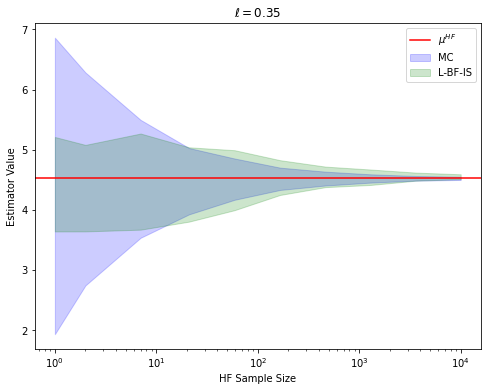

In [31]:
scale = 1.94
plt.figure(figsize=(8,6))
plt.fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='b',alpha=0.2,label='MC')
plt.fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='g',alpha=0.2,label='L-BF-IS')
plt.axhline(ExH,c='r',label=r'$\mu^{HF}$')
plt.xscale('log')
plt.xlabel('HF Sample Size')
plt.ylabel('Estimator Value')
plt.legend()
plt.title(r'$\ell=0.35$')
# plt.savefig('dim1000-l-035.pdf',format='pdf',dpi=200)

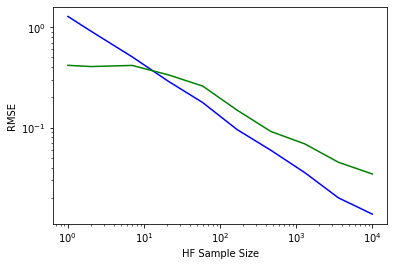

In [33]:
MC_err = ((np.array(MC) - ExH.item())**2)
IS_err = ((np.array(IS) - ExH.item())**2)

MC_rmse  = np.sqrt(np.nanmean(MC_err, axis=0))
IS_rmse  = np.sqrt(np.nanmean(IS_err, axis=0))

plt.plot(MC_N_lst, MC_rmse,color='b',alpha=1.0,label='MC')
plt.plot(MC_N_lst, IS_rmse,color='g',alpha=1.0,label='L-BF-IS')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('HF Sample Size')
plt.ylabel('RMSE')

# plt.savefig('dim1000-l-035-rmse.pdf',format='pdf',dpi=200)

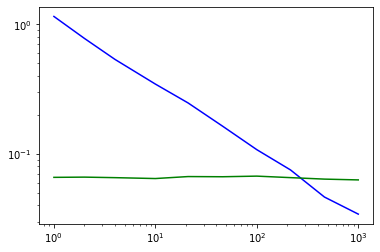

In [224]:
MC_err = np.abs((np.array(MC) - ExH.item()))
IS_err = np.abs((np.array(IS) - ExH.item()))

MC_rmse  = np.nanmean(MC_err, axis=0)
IS_rmse  = np.nanmean(IS_err, axis=0)

plt.plot(MC_N_lst, MC_rmse,color='b',alpha=1.0,label='MC')
plt.plot(MC_N_lst, IS_rmse,color='g',alpha=1.0,label='L-BF-IS')
plt.xscale('log')
plt.yscale('log')

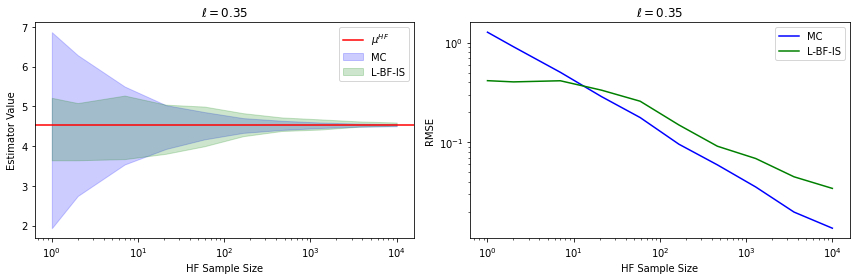

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='b',alpha=0.2,label='MC')
axs[0].fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='g',alpha=0.2,label='L-BF-IS')
axs[0].axhline(ExH,c='r',label=r'$\mu^{HF}$')
axs[0].set_xscale('log')
axs[0].set_xlabel('HF Sample Size')
axs[0].set_ylabel('Estimator Value')
axs[0].legend()
axs[0].set_title(r'$\ell=0.35$')

axs[1].plot(MC_N_lst, MC_rmse,color='b',alpha=1.0,label='MC')
axs[1].plot(MC_N_lst, IS_rmse,color='g',alpha=1.0,label='L-BF-IS')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('HF Sample Size')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].set_title(r'$\ell=0.35$')

fig.tight_layout()
# fig.savefig('dim-1000-l035.pdf',format='pdf',dpi=200)

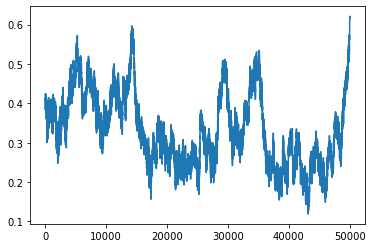

In [235]:
plt.plot(xi_q_lst[50000:,0])